(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=970442, Thu Oct 30 15:11:05 2025)
termination on maxiter=16
final/bestever f-value = 2.451746e-02 7.838991e-03 after 96/79 evaluations
incumbent solution: [0.7634432, 0.73233309]
std deviation: [0.01613117, 0.02031694]

Best solution found:
x* = [0.74218554 0.74938038]
f(x*) = 0.007838990625590462


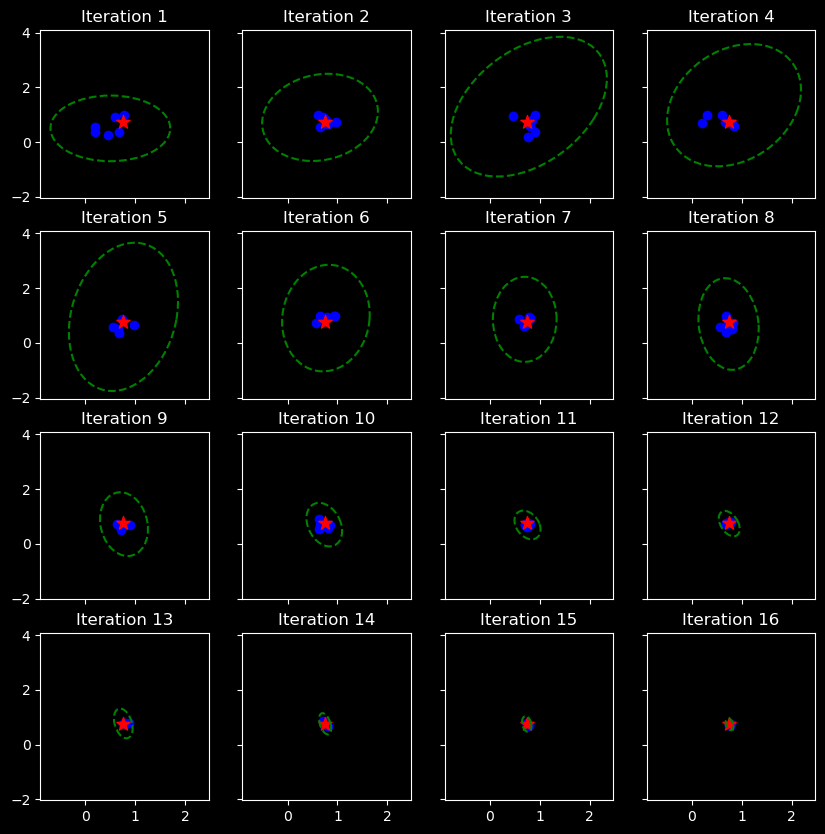

In [ ]:
import cma
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse

target = np.array((0.75, 0.75))


# Define the objective function
def evaluate(point):
    # pythagorean distance to target
    return np.sqrt(np.sum((point - target) ** 2))


# Points are sampled from this iso-probability contour (aka the curvature of the objective function) distribution
def covariance_ellipse(mean, sigma, k=2.0, **kwargs):
    # eigendecomposition: Sigma = Q diag(vals) Q^T
    vals, vecs = np.linalg.eigh(sigma)
    # vals = np.maximum(vals, 0)  # clamp tiny negatives
    order = np.argsort(vals)[::-1]
    vals, vecs = vals[order], vecs[:, order]
    # ellipse axis lengths (full width/height, not radii)
    width, height = 2 * k * np.sqrt(np.maximum(vals, 0))
    # rotation angle (deg) from the first eigenvector
    angle = np.degrees(np.arctan2(vecs[1, 0], vecs[0, 0]))
    return Ellipse(
        xy=mean,
        width=width,
        height=height,
        angle=angle,
        fill=False,
        linestyle="--",
        **kwargs,
    )


# Initial guess
x0 = [0.5, 0.5]  # starting mean
sigma0 = 0.6  # initial standard deviation (step size)
maxiter = 16
options = {
    "maxiter": maxiter,
    "verb_disp": 1,
    "bounds": [[0, 0], [1, 1]],
}  # optimization options

# Run CMA-ES optimization
es = cma.CMAEvolutionStrategy(x0, sigma0, options)

plotnums = int(np.sqrt(maxiter))
fig, axs = plt.subplots(
    plotnums,
    plotnums,
    num="CMA-ES Optimization",
    sharex=True,
    sharey=True,
    figsize=(10, 10),
)
points = np.zeros((maxiter, es.popsize, 2))
covs = np.zeros((maxiter, 2, 2))
means = np.zeros((maxiter, 2))

# es.optimize(evaluate)

# Manually run the optimization loop to log data for visualization
while not es.stop():
    # log current mean and covariance before sampling
    means[es.countiter] = es.mean
    covs[es.countiter] = (es.sigma**2) * np.array(es.C)  # full covariance

    X = es.ask()  # sample new solutions
    points[es.countiter] = np.array(X)

    fitnesses = [evaluate(x) for x in X]  # evaluate solutions
    es.tell(X, fitnesses)  # inform CMA-ES of the fitnesses

    # es.disp()  # display current status
    # es.logger.add()  # log the current generation

es.result_pretty()  # print the result
# es.plot()  # plot the optimization process

# Retrieve the best solution
result = es.result
print("\nBest solution found:")
print("x* =", result.xbest)
print("f(x*) =", result.fbest)

# Visualization of the optimization process
for i in range(maxiter):
    ax = axs[i // plotnums, i % plotnums]
    ax.scatter(points[i, :, 0], points[i, :, 1], c="blue", label="Samples")
    ax.scatter(target[0], target[1], c="red", marker="*", s=100, label="Target")

    # draw an ellipse representing the std deviations
    mean_i = means[i]
    sigma_i = covs[i]
    ell = covariance_ellipse(mean_i, sigma_i, k=2.0, edgecolor="green", linewidth=1.5)

    ax.add_patch(ell)
    ax.set_title(f"Iteration {i + 1}")


plt.show()